In [236]:
from astropy.io import fits 
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
from astroquery.jplhorizons import Horizons
from astropy.wcs import WCS
import cv2
from astropy.stats import sigma_clipped_stats
from copy import deepcopy

In [329]:
file = '/Users/rri38/Documents/work/data/mjo/moa/A6394-lsst1-R-3_cal.fits.gz'
file = '/Users/rri38/Documents/work/data/mjo/moa/A6396-lsst2-R-1_cal.fits.gz'
file = '/Users/rri38/Documents/work/data/mjo/moa/A6396-lsst2-R-8_cal.fits.gz'
#file = '/Users/rri38/Documents/work/data/mjo/moa/A6396-lsst2-R-2_cal.fits.gz'

#open the FITS file
hdul = fits.open(file)
image = hdul[0].data
image -= np.nanmedian(image)
gray = deepcopy(image)
gray[gray > np.percentile(gray,70)] = np.percentile(gray,70)
gray[gray < np.percentile(gray,70)] = np.percentile(gray,16)
mean, med, std = sigma_clipped_stats(image)
#gray[gray < std] = 0
#convert data to grayscale
gray = (gray*255/np.max(gray)).astype('uint8')
kernel_size = 9
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

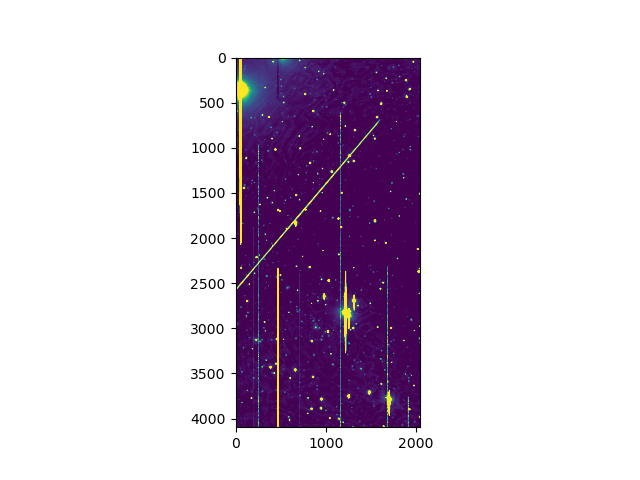

In [330]:
plt.figure()
plt.imshow(image,vmin=0,vmax=10)

In [331]:
arr = deepcopy(image)

threshold = np.percentile(arr,60)

# create a copy of the array
arr_copy = arr.copy()

# set all values below the threshold to zero
arr_copy[arr_copy < threshold] = 0

# create a structuring element for morphological dilation
kernel = np.ones((9, 9))

# dilate the array
dilated = cv2.dilate(arr_copy, kernel, iterations=1)
dilated[dilated<10]  = 0
# set all non-zero values in the dilated array that are not connected to other non-zero values to zero
arr[(arr_copy != 0) & (dilated == 0)] = 0



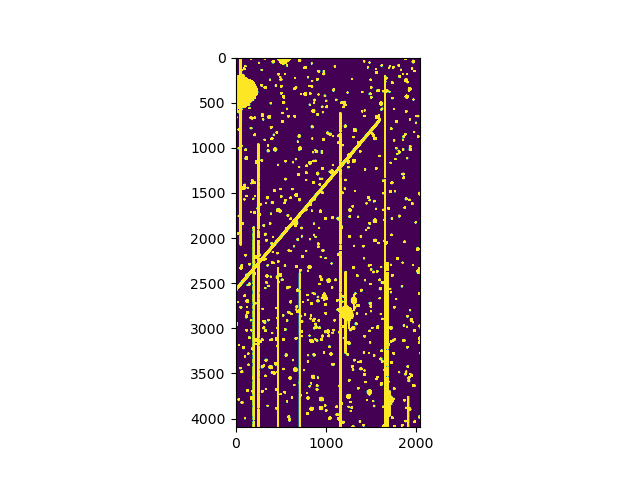

In [332]:
d = (dilated > 0) * 1
gray = (d*255/np.max(d)).astype('uint8')
plt.figure()
plt.imshow(gray,vmax=4)

In [333]:
d = (dilated > 0) * 1
gray = (d*255/np.max(d)).astype('uint8')
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(gray, low_threshold, high_threshold)

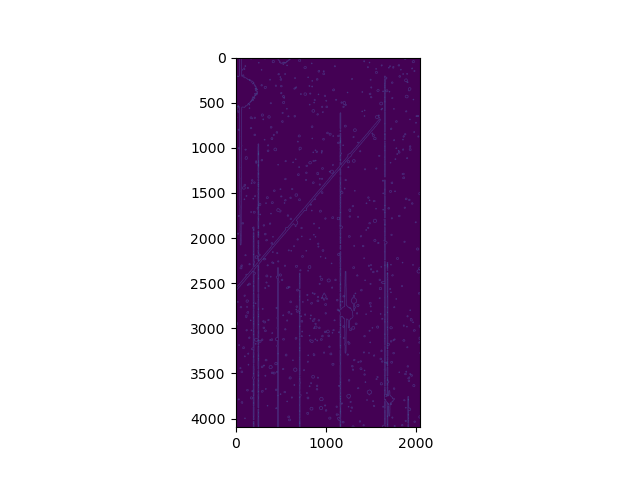

In [334]:
plt.figure()
plt.imshow(edges)

In [343]:
lines = cv2.HoughLinesP(
                        edges, # Input edge image
                        1, # Distance resolution in pixels
                        np.pi/180, # Angle resolution in radians
                        threshold=100, # Min number of votes for valid line
                        minLineLength=200, # Min allowed length of line
                        maxLineGap=70 # Max allowed gap between line for joining them
                        )

good = []
for i in range(len(lines)):
    line = lines[i]
    x1, y1, x2, y2 = line[0]
    # calculate the angle of the line
    angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
    if abs(angle) < 85:
        good += [i]
good = np.array(good)

lines = lines[good]

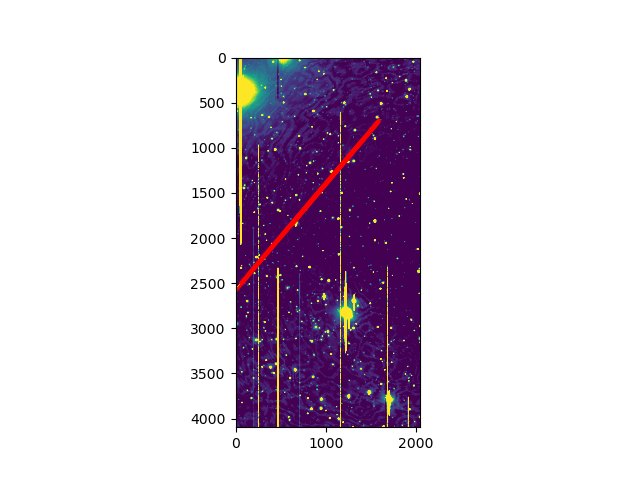

In [344]:
plt.figure()
plt.imshow(image,vmin=0,vmax=4)
for line in lines:
    x1, y1, x2, y2 = line[0]
    plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2)


In [339]:
# define the angle tolerance for grouping lines
angle_tolerance = 5
# create an empty list to store the consolidated lines
consolidated_lines = []


# loop through the lines detected by HoughLinesP
for line in lines:
    x1, y1, x2, y2 = line[0]
    # calculate the angle of the line
    angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
    # round the angle to the nearest multiple of the angle tolerance
    angle = round(angle / angle_tolerance) * angle_tolerance
    # check if a line with a similar angle has already been consolidated
    found = False
    for consolidated_line in consolidated_lines:
        if abs(consolidated_line[0] - angle) < angle_tolerance:
            # if a similar line has been found, add the current line to the consolidated line
            consolidated_line[1] += [(x1, y1), (x2, y2)]
            found = True
            break
    if not found:
        # if no similar line has been found, create a new consolidated line
        consolidated_lines.append([angle, [(x1, y1), (x2, y2)]])

# loop through the consolidated lines and calculate the average line
for consolidated_line in consolidated_lines:
    angle = consolidated_line[0]
    points = np.array(consolidated_line[1])
    x = points[:,0]
    y = points[:,1]
    # use polyfit function to fit a line through the points and get the slope and intercept
    coefs = np.polyfit(x, y, 1)
    slope = coefs[0]
    intercept = coefs[1]
    # use the slope and intercept to get the start and end points of the average line
    x1 = np.min(x)
    y1 = int(slope * x1 + intercept)
    x2 = np.max(x)
    y2 = int(slope * x2 + intercept)


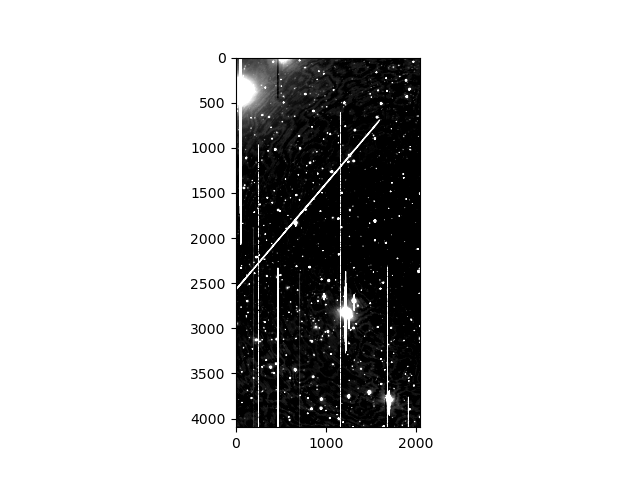

In [345]:
plt.figure()
plt.imshow(image,vmin=0,vmax=4,cmap='gray')

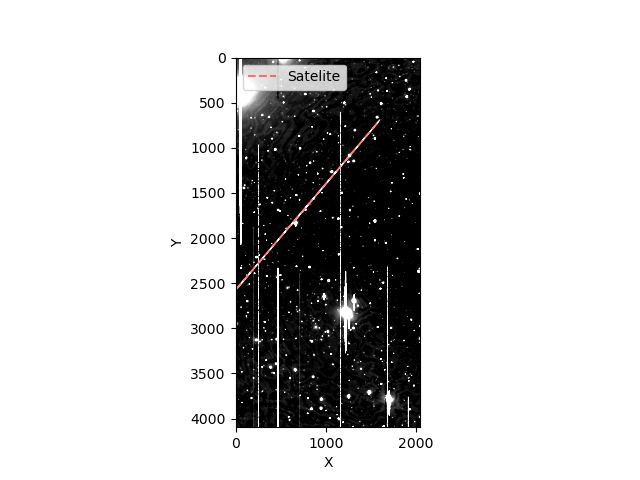

In [340]:
# loop through the consolidated lines and plot the average line
plt.figure()
plt.imshow(image,vmin=0,vmax=4,cmap='gray')
for consolidated_line in consolidated_lines:
    angle = consolidated_line[0]
    points = np.array(consolidated_line[1])
    x = points[:,0]
    y = points[:,1]
    coefs = np.polyfit(x, y, 1)
    slope = coefs[0]
    intercept = coefs[1]
    x1 = np.min(x)
    y1 = int(slope * x1 + intercept)
    x2 = np.max(x)
    y2 = int(slope * x2 + intercept)
    # create the x and y points for the consolidated line
    x_points = [x1, x2]
    y_points = [y1, y2]

    # plot the consolidated line
    plt.plot(x_points, y_points, '--r', label='Satelite',alpha = .5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper left')


In [347]:
consolidated_line

2

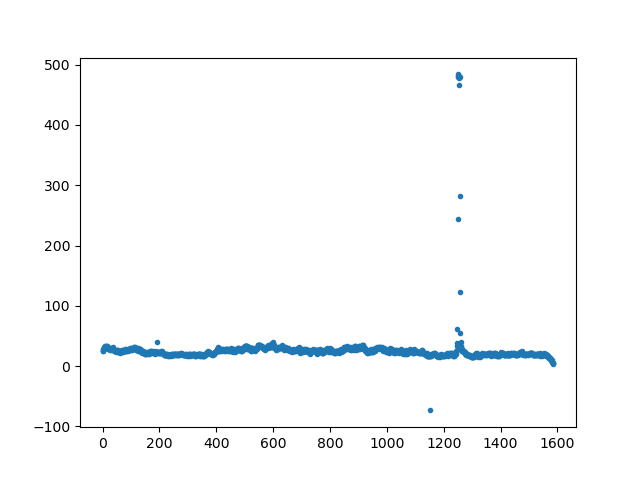

In [391]:
plt.figure()
plt.plot(lc,'.')

## Try to get a LC

In [386]:
# create a black image with the same size as the input image
mask = np.zeros_like(image)

# loop through the consolidated lines
sat_mask = []
for consolidated_line in consolidated_lines:
    angle = consolidated_line[0]
    points = np.array(consolidated_line[1])
    x = points[:,0]
    y = points[:,1]
    coefs = np.polyfit(x, y, 1)
    slope = coefs[0]
    intercept = coefs[1]
    x1 = np.min(x)
    xx = np.arange(np.min(x),np.max(x))
    y1 = int(slope * x1 + intercept)
    x2 = np.max(x)
    y2 = int(slope * x2 + intercept)
    yy = (slope * xx + intercept).astype(int)
    # Draw the line on the black image using cv2.line
    tmp = cv2.line(mask, (x1, y1), (x2, y2), (255, 255, 255), thickness=17)
    tmp[tmp >0] = 8
    sat_mask += [tmp]

# The pixels that are covered by the line will have a value of 255 in the mask
# You can use this mask to extract the pixels that belong to the lines
sat_mask = np.array(sat_mask).astype(int)

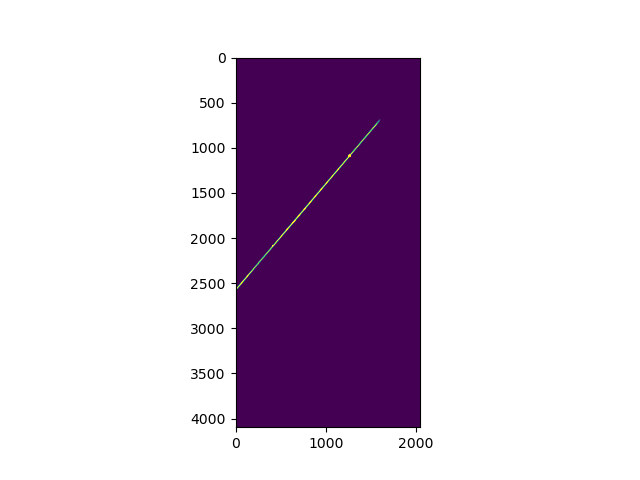

In [387]:
plt.figure()
plt.imshow(sat_mask[0]*image,vmin=0,vmax=100)

In [392]:
image.shape

(4096, 2048)

In [394]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 4096                                                  
EXTEND  =                    T                                                  
OBSTEL  = '  MOA-II telescope' / Observing telescope                            
CAMERA  = '          MOA-cam3' / Observing camera                               
FNUM    = '             f2.91' / F number                                       
OBSVAT  = '        Mount John' / Observatory                                    
LOGITUD =             -170.467 / Longitude (Negative means East)                
LATITUD =              -43.983 / Latitude (Negative means South)                
HEIGHT  =                102